In [1]:
%load_ext autoreload
%autoreload 2

In [108]:
import opendatasets as od
import pandas as pd
import numpy as np
import os
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, roc_curve, plot_confusion_matrix

from sklearn.compose import make_column_transformer

from sklearn.impute import KNNImputer
from feature_engine import imputation
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.discretisation import EqualFrequencyDiscretiser, DecisionTreeDiscretiser
from feature_engine.encoding import OrdinalEncoder, OneHotEncoder, RareLabelEncoder
from feature_engine import transformation as vt
from feature_engine.creation import CyclicalTransformer, MathematicalCombination, CombineWithReferenceFeature
from feature_engine.selection import RecursiveFeatureElimination, DropConstantFeatures, DropCorrelatedFeatures, DropDuplicateFeatures, SelectByShuffling, SmartCorrelatedSelection

import lightgbm as lgb
import h2o
from h2o.automl import H2OAutoML

from imblearn.over_sampling import RandomOverSampler
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from src.pipe_func import *
from src.eda_functions import *

import warnings
warnings.filterwarnings("ignore")



## Load data and split train and test

In [176]:
# load dataset
song_df = pd.read_csv("../../data/train.csv").set_index('id')
test = pd.read_csv("../../data/test.csv").set_index('id')
song_df.head()


,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
id,,,,,,,,,,,,,,
0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0


In [4]:
# convert column to categorical
cat_vars = ['key','audio_mode','time_signature','song_popularity']
song_df[cat_vars] = song_df[cat_vars].astype("object")
test[['key','audio_mode','time_signature']] = test[['key','audio_mode','time_signature']].astype("object")


cont_vars = [var for var in song_df.columns if var not in cat_vars]
cat_vars = ['key','audio_mode','time_signature'] # remove target variable

In [5]:
# split independent and dependent variables
y = song_df['song_popularity'].astype('int')
X = song_df[cont_vars + ['key','audio_mode','time_signature']]


## Missing imputation

In [59]:
add_miss_imputation = imputation.AddMissingIndicator(missing_only=True)
cont_imputation = imputation.MeanMedianImputer(imputation_method='median', variables=cont_vars)
cat_imputation = imputation.CategoricalImputer( variables= cat_vars, return_object=True)

imputation_pipe = Pipeline(steps=[
    ('add_miss_imputation', add_miss_imputation),
    ('cont_imputation', cont_imputation),
    ('cat_imputation', cat_imputation),
])

X_1step = imputation_pipe.fit_transform(X)
X_1step


,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,audio_mode,time_signature,song_duration_ms_na,acousticness_na,danceability_na,energy_na,instrumentalness_na,liveness_na,loudness_na,key_na
id,,,,,,,,,,,,,,,,,,,,,
0,212990.0,0.642286,0.856520,0.707073,0.002001,0.135945,-5.619088,0.082570,158.386236,0.734642,...,0,4,0,0,0,0,0,1,0,0
1,186660.0,0.054866,0.733289,0.835545,0.000996,0.436428,-5.236965,0.127358,102.752988,0.711531,...,1,3,1,0,0,0,0,0,0,0
2,193213.0,0.140532,0.188387,0.783524,-0.002694,0.170499,-4.951759,0.052282,178.685791,0.425536,...,0,3,0,1,0,0,0,0,0,0
3,249893.0,0.488660,0.585234,0.552685,0.000608,0.094805,-7.893694,0.035618,128.715630,0.453597,...,0,3,0,0,0,0,0,0,0,0
4,165969.0,0.493017,0.608234,0.740982,0.002033,0.094891,-2.684095,0.050746,121.928157,0.741311,...,0,4,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,237799.0,0.140532,0.748942,0.511234,0.002913,0.173803,-8.853673,0.078060,168.262924,0.178159,...,0,3,0,1,0,0,0,0,0,0
39996,191119.0,0.067488,0.672830,0.889685,0.001225,0.122924,-7.798993,0.188607,110.684544,0.790626,...,0,3,0,0,0,0,0,0,0,0
39997,160879.0,0.877431,0.409065,0.292671,0.001974,0.110664,-15.378585,0.031294,99.556074,0.177947,...,0,3,0,0,0,0,1,0,0,0


## feature discretization

In [60]:

equal_disc = EqualFrequencyDiscretiser(variables=cont_vars, q = 10)
equal_temp = equal_disc.fit_transform(X_1step[cont_vars]).add_suffix('_equaldisc')

tree_disc = DecisionTreeDiscretiser(
    variables= cont_vars,
    cv = 5, 
    scoring='roc_auc',
    regression=False,
    random_state=123,
    param_grid={
        'max_depth' : [1,2,3,4],
        'min_samples_leaf' : [10,4]
    }
)
tree_temp = tree_disc.fit_transform(X_1step, y)
tree_temp = tree_temp[cont_vars].add_suffix('_treedisc')

X_1step_disc = pd.concat([X_1step, equal_temp, tree_temp], axis = 1, join= 'inner')
X_1step_disc

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,song_duration_ms_treedisc,acousticness_treedisc,danceability_treedisc,energy_treedisc,instrumentalness_treedisc,liveness_treedisc,loudness_treedisc,speechiness_treedisc,tempo_treedisc,audio_valence_treedisc
id,,,,,,,,,,,,,,,,,,,,,
0,212990.0,0.642286,0.856520,0.707073,0.002001,0.135945,-5.619088,0.082570,158.386236,0.734642,...,0.387914,0.357742,0.391685,0.367787,0.344856,0.375079,0.351437,0.373720,0.374828,0.367336
1,186660.0,0.054866,0.733289,0.835545,0.000996,0.436428,-5.236965,0.127358,102.752988,0.711531,...,0.371277,0.366248,0.391685,0.330039,0.367931,0.400789,0.351437,0.373720,0.368645,0.367336
2,193213.0,0.140532,0.188387,0.783524,-0.002694,0.170499,-4.951759,0.052282,178.685791,0.425536,...,0.387914,0.366248,0.304850,0.367787,0.402734,0.375079,0.351437,0.373720,0.374828,0.393923
3,249893.0,0.488660,0.585234,0.552685,0.000608,0.094805,-7.893694,0.035618,128.715630,0.453597,...,0.346313,0.357742,0.362728,0.398104,0.367931,0.331513,0.375505,0.348487,0.374828,0.393923
4,165969.0,0.493017,0.608234,0.740982,0.002033,0.094891,-2.684095,0.050746,121.928157,0.741311,...,0.334712,0.357742,0.362728,0.367787,0.344856,0.331513,0.351437,0.373720,0.340685,0.367336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,237799.0,0.140532,0.748942,0.511234,0.002913,0.173803,-8.853673,0.078060,168.262924,0.178159,...,0.346313,0.366248,0.391685,0.292259,0.344856,0.375079,0.375505,0.373720,0.374828,0.393923
39996,191119.0,0.067488,0.672830,0.889685,0.001225,0.122924,-7.798993,0.188607,110.684544,0.790626,...,0.387914,0.366248,0.344530,0.330039,0.367931,0.375079,0.375505,0.373720,0.292804,0.328916
39997,160879.0,0.877431,0.409065,0.292671,0.001974,0.110664,-15.378585,0.031294,99.556074,0.177947,...,0.334712,0.439252,0.362728,0.370648,0.344856,0.375079,0.439523,0.331063,0.368645,0.393923


## feature transformation

In [61]:
lt = vt.LogTransformer(['liveness'])
rt = vt.ReciprocalTransformer(['tempo'])
pt = vt.PowerTransformer(['danceability', 'audio_valence' ])
box_t = vt.BoxCoxTransformer(['speechiness'])
yt = vt.YeoJohnsonTransformer(['song_duration_ms', 'loudness'])

rare_encoding = RareLabelEncoder(
    tol = 0.05,
    n_categories = 2,
    variables = ['key','audio_mode','time_signature']
)

ohe = dummify(variables=cat_vars, drop_first=True)

transformation_pipe = Pipeline(steps=[
    ('LogTransformer', lt),
    ('ReciprocalTransformer', rt),
    ('PowerTransformer', pt),
    ('BoxCoxTransformer', box_t),
    ('YeoJohnsonTransformer', yt),
    ('rare_encoding', rare_encoding),
    ('dummify', ohe),
])


X_2step = transformation_pipe.fit_transform(X_1step_disc)
X_2step

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,key_6.0,key_7.0,key_8.0,key_9.0,key_10.0,key_Missing,key_Rare,audio_mode_1,time_signature_4,time_signature_Rare
id,,,,,,,,,,,,,,,,,,,,,
0,1091.578753,0.642286,0.925484,0.707073,0.002001,-1.995504,-1.486563,-5.647440,0.006314,0.857112,...,0,0,0,0,1,0,0,0,1,0
1,1019.539204,0.054866,0.856323,0.835545,0.000996,-0.829132,-1.450249,-3.999327,0.009732,0.843523,...,0,0,1,0,0,0,0,1,0,0
2,1037.904924,0.140532,0.434036,0.783524,-0.002694,-1.769028,-1.421259,-7.903503,0.005596,0.652331,...,0,0,0,0,0,0,0,0,0,0
3,1185.646548,0.488660,0.765006,0.552685,0.000608,-2.355932,-1.658706,-10.324775,0.007769,0.673496,...,0,0,0,0,0,0,0,0,0,0
4,959.402294,0.493017,0.779893,0.740982,0.002033,-2.355026,-1.102492,-8.072694,0.008202,0.860994,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,1155.607489,0.140532,0.865414,0.511234,0.002913,-1.749831,-1.715360,-5.893307,0.005943,0.422089,...,0,0,0,0,0,0,0,0,0,0
39996,1032.069400,0.067488,0.820262,0.889685,0.001225,-2.096186,-1.652700,-2.827285,0.009035,0.889171,...,0,0,0,0,0,0,0,0,0,0
39997,944.061266,0.877431,0.639582,0.292671,0.001974,-2.201258,-1.974560,-11.271628,0.010045,0.421838,...,0,0,0,0,1,0,0,0,0,0


## feature engineering 1 - kmeans

In [66]:
# create clusters feature 
n_clusters = 8

kmeans = KMeans(n_clusters=n_clusters, max_iter=500, n_init=20, random_state=123)
cluster_cols = [f"cluster{i+1}" for i in range(n_clusters)]

minmax = MinMaxScaler()
X_3step =  pd.DataFrame(minmax.fit_transform(X_2step[cont_vars]), columns=X_2step[cont_vars].columns)

X_kmeans = kmeans.fit_transform(X_3step)
X_kmeans = pd.DataFrame(X_kmeans, columns=cluster_cols, index = X.index)
X_kmeans
X_3step = pd.concat([X_2step, X_kmeans], axis = 1, join= 'inner')
X_3step


,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,time_signature_4,time_signature_Rare,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8
id,,,,,,,,,,,,,,,,,,,,,
0,1091.578753,0.642286,0.925484,0.707073,0.002001,-1.995504,-1.486563,-5.647440,0.006314,0.857112,...,1,0,0.650748,0.607476,0.341424,0.754424,0.573559,0.772677,0.976451,0.763104
1,1019.539204,0.054866,0.856323,0.835545,0.000996,-0.829132,-1.450249,-3.999327,0.009732,0.843523,...,0,0,0.187601,0.482233,0.646683,1.058643,0.356274,0.577048,0.986496,0.638685
2,1037.904924,0.140532,0.434036,0.783524,-0.002694,-1.769028,-1.421259,-7.903503,0.005596,0.652331,...,0,0,0.649227,0.604044,0.748007,0.931600,0.664120,0.253149,0.919961,0.604618
3,1185.646548,0.488660,0.765006,0.552685,0.000608,-2.355932,-1.658706,-10.324775,0.007769,0.673496,...,0,0,0.694868,0.492230,0.337560,0.517216,0.623240,0.632156,0.823396,0.450202
4,959.402294,0.493017,0.779893,0.740982,0.002033,-2.355026,-1.102492,-8.072694,0.008202,0.860994,...,1,0,0.611734,0.439034,0.387465,0.773293,0.506610,0.598804,0.925480,0.662821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,1155.607489,0.140532,0.865414,0.511234,0.002913,-1.749831,-1.715360,-5.893307,0.005943,0.422089,...,0,0,0.660950,0.657492,0.676786,0.841471,0.614895,0.658383,0.901608,0.470656
39996,1032.069400,0.067488,0.820262,0.889685,0.001225,-2.096186,-1.652700,-2.827285,0.009035,0.889171,...,0,0,0.452359,0.425329,0.603086,1.038055,0.194693,0.526298,0.963148,0.619041
39997,944.061266,0.877431,0.639582,0.292671,0.001974,-2.201258,-1.974560,-11.271628,0.010045,0.421838,...,0,0,1.148509,1.041549,0.717905,0.240204,1.117492,1.092140,1.016782,0.795501


## Feature engineering 2- interaction

In [67]:
interact_fe = CombineWithReferenceFeature(
    variables_to_combine = cont_vars,
    reference_variables=cont_vars,
    operations=['sub', 'div','add'])

X_4step = interact_fe.fit_transform(X_3step)
X_4step.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,song_duration_ms_add_audio_valence,acousticness_add_audio_valence,danceability_add_audio_valence,energy_add_audio_valence,instrumentalness_add_audio_valence,liveness_add_audio_valence,loudness_add_audio_valence,speechiness_add_audio_valence,tempo_add_audio_valence,audio_valence_add_audio_valence
id,,,,,,,,,,,,,,,,,,,,,
0,1091.578753,0.642286,0.925484,0.707073,0.002001,-1.995504,-1.486563,-5.647440,0.006314,0.857112,...,1092.435865,1.499398,1.782596,1.564185,0.859114,-1.138391,-0.629451,-4.790328,0.863426,1.714225
1,1019.539204,0.054866,0.856323,0.835545,0.000996,-0.829132,-1.450249,-3.999327,0.009732,0.843523,...,1020.382727,0.898388,1.699846,1.679068,0.844518,0.014391,-0.606726,-3.155805,0.853255,1.687045
2,1037.904924,0.140532,0.434036,0.783524,-0.002694,-1.769028,-1.421259,-7.903503,0.005596,0.652331,...,1038.557256,0.792864,1.086367,1.435855,0.649637,-1.116697,-0.768928,-7.251171,0.657928,1.304662
3,1185.646548,0.488660,0.765006,0.552685,0.000608,-2.355932,-1.658706,-10.324775,0.007769,0.673496,...,1186.320044,1.162156,1.438502,1.226181,0.674104,-1.682436,-0.985210,-9.651279,0.681265,1.346992
4,959.402294,0.493017,0.779893,0.740982,0.002033,-2.355026,-1.102492,-8.072694,0.008202,0.860994,...,960.263288,1.354011,1.640887,1.601976,0.863027,-1.494032,-0.241498,-7.211700,0.869196,1.721988


## Feature 3: polynomial features


In [77]:
# create 3 degree polynomial features
poly_fe = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
X_5step_temp = poly_fe.fit_transform(X_4step[cont_vars])
poly_fe_name = poly_fe.get_feature_names(X_4step[cont_vars].columns)
X_5step_temp = pd.DataFrame(X_5step_temp, columns =poly_fe_name)
X_5step_temp.drop(cont_vars, axis =1, inplace=True)
X_5step = pd.concat([X_4step, X_5step_temp], axis=1, join='inner')
X_5step.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,speechiness^3,speechiness^2 tempo,speechiness^2 audio_valence,speechiness tempo^2,speechiness tempo audio_valence,speechiness audio_valence^2,tempo^3,tempo^2 audio_valence,tempo audio_valence^2,audio_valence^3
0,1091.578753,0.642286,0.925484,0.707073,0.002001,-1.995504,-1.486563,-5.647440,0.006314,0.857112,...,-180.117108,0.201366,27.336383,-0.000225,-0.030561,-4.148844,2.516794e-07,0.000034,0.004638,0.629670
1,1019.539204,0.054866,0.856323,0.835545,0.000996,-0.829132,-1.450249,-3.999327,0.009732,0.843523,...,-63.967719,0.155661,13.491825,-0.000379,-0.032831,-2.845644,9.217574e-07,0.000080,0.006925,0.600192
2,1037.904924,0.140532,0.434036,0.783524,-0.002694,-1.769028,-1.421259,-7.903503,0.005596,0.652331,...,-493.695084,0.349582,40.748100,-0.000248,-0.028853,-3.363225,1.752790e-07,0.000020,0.002381,0.277590
3,1185.646548,0.488660,0.765006,0.552685,0.000608,-2.355932,-1.658706,-10.324775,0.007769,0.673496,...,-1100.631036,0.828190,71.795330,-0.000623,-0.054024,-4.683286,4.689280e-07,0.000041,0.003524,0.305496
4,959.402294,0.493017,0.779893,0.740982,0.002033,-2.355026,-1.102492,-8.072694,0.008202,0.860994,...,-526.084502,0.534482,56.109592,-0.000543,-0.057005,-5.984374,5.516809e-07,0.000058,0.006080,0.638264


## Feature scaling before modeling

In [117]:
mm_scaler = MinMaxScaler()
X_5step_scaled =  pd.DataFrame(mm_scaler.fit_transform(X_5step), columns=X_5step.columns)
X_5step_scaled.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,speechiness^3,speechiness^2 tempo,speechiness^2 audio_valence,speechiness tempo^2,speechiness tempo audio_valence,speechiness audio_valence^2,tempo^3,tempo^2 audio_valence,tempo audio_valence^2,audio_valence^3
0,0.551603,0.607912,0.931248,0.680564,0.005926,0.435094,0.466945,0.716889,0.151568,0.827907,...,0.970197,0.064058,0.088893,0.929125,0.823946,0.737838,0.038313,0.128768,0.304856,0.608363
1,0.496941,0.063417,0.841273,0.803926,0.004995,0.755137,0.488299,0.810981,0.447489,0.812731,...,0.989450,0.049256,0.043439,0.873798,0.809968,0.821578,0.202162,0.331272,0.459152,0.579812
2,0.510877,0.142824,0.291894,0.753974,0.001578,0.497237,0.505347,0.588088,0.089477,0.599221,...,0.918217,0.112059,0.132927,0.921055,0.834462,0.788320,0.019632,0.067938,0.152555,0.267357
3,0.622980,0.465512,0.722473,0.532317,0.004636,0.336195,0.365716,0.449856,0.277557,0.622856,...,0.817608,0.267062,0.234861,0.785806,0.679475,0.703497,0.091435,0.157485,0.229660,0.294385
4,0.451310,0.469551,0.741841,0.713124,0.005956,0.336444,0.692797,0.578429,0.314996,0.832242,...,0.912848,0.171941,0.183362,0.814671,0.661116,0.619893,0.111670,0.233941,0.402142,0.616686


## Feature selection before modelling

In [90]:
feature_sel_pipe1 = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)),
    ('duplicates', DropDuplicateFeatures()),
    ('correlated', SmartCorrelatedSelection(
        threshold=0.9,
        selection_method = 'variance',
        scoring = 'roc_auc'
        ))
])

# feature_sel_pipe2 = Pipeline([
#     ('constant', DropConstantFeatures(tol=0.998)),
#     ('duplicates', DropDuplicateFeatures()),
#     ('correlated', SmartCorrelatedSelection(
#         threshold=0.9,
#         estimator = RandomForestClassifier(random_state=123),
#         selection_method = 'model_performance',
#         scoring = 'roc_auc'
#         ))
# ])

feature_sel_pipe3 = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)),
    ('duplicates', DropDuplicateFeatures())
])

X_5step_feature_sel_v1 = feature_sel_pipe1.fit_transform(X_5step_scaled)
# X_5step_feature_sel_v2 = feature_sel_pipe2.fit_transform(X_5step_scaled, y)
X_5step_feature_sel_v3 = feature_sel_pipe3.fit_transform(X_5step_scaled)


## Random oversampling

In [92]:
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import  SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN

In [94]:
ros = RandomOverSampler(
        sampling_strategy = 'auto',
        random_state = 123,
        shrinkage = 0.1
    )

sm = SMOTE(
    sampling_strategy = 'auto',
    random_state = 123,
    k_neighbors = 10,
    n_jobs = 4
)

enn = EditedNearestNeighbours(
    sampling_strategy = 'auto',
    n_neighbors = 10,
    kind_sel = 'all',
    n_jobs = 4
)

smenn = SMOTEENN(
    sampling_strategy = 'auto',
    random_state = 123,
    smote = sm,
    enn = enn,
    n_jobs = 4
)

tl = TomekLinks(
    sampling_strategy = 'auto',
    n_jobs = 4
)

smtomek = SMOTETomek(
    sampling_strategy = 'auto',
    random_state = 123,
    smote = sm,
    tomek = tl,
    n_jobs = 4
)

In [95]:
X_res_ros_v1, y_res_ros_v1 = ros.fit_resample(X_5step_feature_sel_v1, y)
X_res_smenn_v1, y_res_smenn_v1 = smenn.fit_resample(X_5step_feature_sel_v1, y)
X_res_smtomek_v1, y_res_smtomek_v1 = smtomek.fit_resample(X_5step_feature_sel_v1, y)


X_res_ros_v3, y_res_ros_v3 = ros.fit_resample(X_5step_feature_sel_v3, y)
X_res_smenn_v3, y_res_smenn_v3 = smenn.fit_resample(X_5step_feature_sel_v3, y)
X_res_smtomek_v3, y_res_smtomek_v3 = smtomek.fit_resample(X_5step_feature_sel_v3, y)


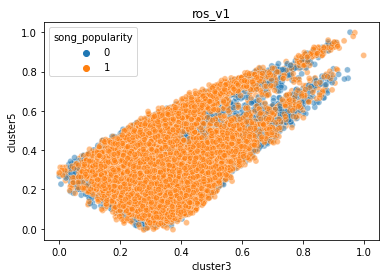

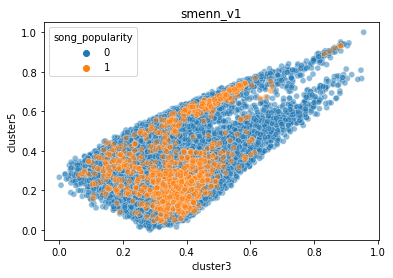

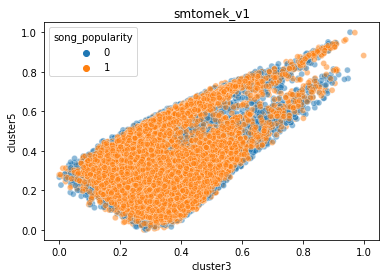

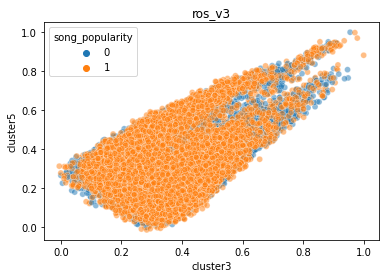

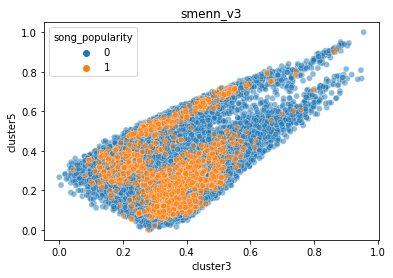

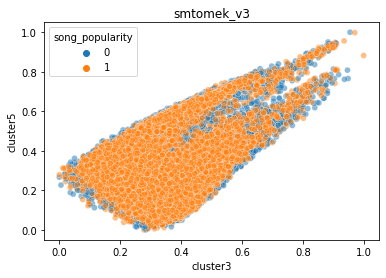

In [103]:
sns.scatterplot(
    data = X_res_ros_v1, x = 'cluster3', y = 'cluster5', hue = y_res_ros_v1, alpha = 0.5
)
plt.title(f'ros_v1')
plt.show()

sns.scatterplot(
    data = X_res_smenn_v1, x = 'cluster3', y = 'cluster5', hue = y_res_smenn_v1, alpha = 0.5
)
plt.title(f'smenn_v1')
plt.show()

sns.scatterplot(
    data = X_res_smtomek_v1, x = 'cluster3', y = 'cluster5', hue = y_res_smtomek_v1, alpha = 0.5
)
plt.title(f'smtomek_v1')
plt.show()

sns.scatterplot(
    data = X_res_ros_v3, x = 'cluster3', y = 'cluster5', hue = y_res_ros_v3, alpha = 0.5
)
plt.title(f'ros_v3')
plt.show()

sns.scatterplot(
    data = X_res_smenn_v3, x = 'cluster3', y = 'cluster5', hue = y_res_smenn_v3, alpha = 0.5
)
plt.title(f'smenn_v3')
plt.show()

sns.scatterplot(
    data = X_res_smtomek_v3, x = 'cluster3', y = 'cluster5', hue = y_res_smtomek_v3, alpha = 0.5
)
plt.title(f'smtomek_v3')
plt.show()

In [109]:

def h2o_automl(train_df, y_col, run_time, fold):
    # initial h2o instance
    h2o.init()

    # change h2o format
    train_hf = h2o.H2OFrame(train_df)
    train_hf[y_col]= train_hf[y_col].asfactor()


    # filter x and y columns
    y_var = y_col
    ignore_fields = [y_var]
    x_var = [i for i in train_df.columns if i not in ignore_fields]

    # cross validation of models
    model = H2OAutoML(max_runtime_secs = run_time, seed = 1, nfolds=fold, project_name = "h2o_5folds")
    model.train(x_var, y_var, train_hf)

    return model



In [113]:
train_smenn_v1 = pd.concat([X_res_smenn_v1, y_res_smenn_v1], axis = 1, join = 'inner')
cv5fold = h2o_automl(train_df=train_smenn_v1, y_col = 'song_popularity', run_time = 1000, fold = 5)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,7 mins 09 secs
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,1 month and 10 days
H2O_cluster_name:,H2O_from_python_benlc_1il1er
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.377 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
13:13:37.879: AutoML: XGBoost is not available; skipping it.
13:13:37.898: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
13:13:37.898: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.
13:21:01.345: New models will be added to existing leaderboard h2o_5folds@@song_popularity (leaderboard frame=null) with already 12 models.
13:21:01.346: AutoML: XGBoost is not available; skipping it.
13:21:01.347: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
13:21:01.347: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

████████
13:22:32.651: StackedEnsemble_BestOfFamily_3_AutoML_2_20220201_132101 [StackedEnsemble best_of_family_1 (built with AUTO metalearner, using top model from each algorithm type)] failed: water.exceptions.H2OIllegalArgumentException: Fail

In [114]:
cv5fold.leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_6_AutoML_2_20220201_132101,0.946355,0.0573609,0.793842,0.174719,0.112936,0.0127546
StackedEnsemble_BestOfFamily_5_AutoML_2_20220201_132101,0.946207,0.0605817,0.783109,0.170917,0.114439,0.0130964
StackedEnsemble_BestOfFamily_7_AutoML_2_20220201_132101,0.945103,0.0581271,0.793426,0.166507,0.112894,0.012745
GBM_grid_1_AutoML_2_20220201_132101_model_15,0.940517,0.0804404,0.777642,0.177416,0.134713,0.0181476
StackedEnsemble_AllModels_1_AutoML_1_20220201_131337,0.94015,0.0570694,0.784827,0.165232,0.111149,0.0123541
StackedEnsemble_BestOfFamily_2_AutoML_1_20220201_131337,0.937687,0.062625,0.75705,0.193687,0.118081,0.0139431
GBM_6_AutoML_2_20220201_132101,0.935866,0.0708602,0.75106,0.193377,0.128201,0.0164356
GBM_1_AutoML_1_20220201_131337,0.935379,0.0709834,0.751313,0.195932,0.128005,0.0163852
StackedEnsemble_BestOfFamily_1_AutoML_1_20220201_131337,0.935234,0.0632984,0.751005,0.193903,0.118718,0.014094
DRF_2_AutoML_2_20220201_132101,0.935091,0.0932961,0.74647,0.164545,0.144996,0.021024


## Testing pipeline

In [118]:

X_1step_test = imputation_pipe.fit_transform(test)
equal_temp_test = equal_disc.transform(X_1step_test[cont_vars]).add_suffix('_equaldisc')
tree_temp_test = tree_disc.transform(X_1step_test)
tree_temp_test = tree_temp_test[cont_vars].add_suffix('_treedisc')

X_1step_disc_test = pd.concat([X_1step_test, equal_temp_test, tree_temp_test], axis = 1, join= 'inner')


X_2step_test = transformation_pipe.transform(X_1step_disc_test)

temp_mm_test =  pd.DataFrame(minmax.transform(X_2step_test[cont_vars]), columns=X_2step_test[cont_vars].columns)

X_kmeans_test = kmeans.transform(temp_mm_test)
X_kmeans_test = pd.DataFrame(X_kmeans_test, columns=cluster_cols, index = test.index)

X_3step_test = pd.concat([X_2step_test, X_kmeans_test], axis = 1, join= 'inner')


X_4step_test = interact_fe.transform(X_3step_test)

X_5step_temp_test = poly_fe.transform(X_4step_test[cont_vars])
poly_fe_name = poly_fe.get_feature_names(X_4step_test[cont_vars].columns)
X_5step_temp_test = pd.DataFrame(X_5step_temp_test, columns =poly_fe_name)
X_5step_temp_test.drop(cont_vars, axis =1, inplace=True)
X_5step_test = pd.concat([X_4step_test, X_5step_temp_test], axis=1, join='inner')

X_5step_scaled_test =  pd.DataFrame(mm_scaler.transform(X_5step_test), columns=X_5step_test.columns)

X_5step_feature_sel_v1_test = feature_sel_pipe1.fit_transform(X_5step_scaled_test)


In [120]:

test_hf = h2o.H2OFrame(X_5step_feature_sel_v1_test)
submission = cv5fold.leader.predict(test_hf)
submission_df = submission.as_data_frame()
submission_final = submission_df[['p1']].reset_index()
submission_final.columns = ['id', 'song_popularity']


submission_final.to_csv('submission_smenn_v1.csv', index=False)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [123]:
submission_final.to_csv('submission_smenn_v1.csv', index=False)

## Testing V2

In [124]:
train_smenn_v3 = pd.concat([X_res_smenn_v3, y_res_smenn_v3], axis = 1, join = 'inner')
cv5fold_smenn_v3 = h2o_automl(train_df=train_smenn_v3, y_col = 'song_popularity', run_time = 1800, fold = 5)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,39 mins 26 secs
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,1 month and 10 days
H2O_cluster_name:,H2O_from_python_benlc_1il1er
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.407 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
13:13:37.879: AutoML: XGBoost is not available; skipping it.
13:13:37.898: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
13:13:37.898: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.
13:21:01.345: New models will be added to existing leaderboard h2o_5folds@@song_popularity (leaderboard frame=null) with already 12 models.
13:21:01.346: AutoML: XGBoost is not available; skipping it.
13:21:01.347: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
13:21:01.347: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.
13:22:32.651: StackedEnsemble_BestOfFamily_3_AutoML_2_20220201_132101 [StackedEnsemble best_of_family_1 (built with AUTO metalearner, using top model from each algorithm type)] failed: water.exceptions.H2OIllegalArgumentException: Failed to find

In [125]:
cv5fold_smenn_v3.leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_6_AutoML_2_20220201_132101,0.946355,0.0573609,0.793842,0.174719,0.112936,0.0127546
StackedEnsemble_BestOfFamily_5_AutoML_2_20220201_132101,0.946207,0.0605817,0.783109,0.170917,0.114439,0.0130964
StackedEnsemble_BestOfFamily_7_AutoML_2_20220201_132101,0.945103,0.0581271,0.793426,0.166507,0.112894,0.012745
GBM_11_AutoML_3_20220201_135334,0.943179,0.0778495,0.795111,0.175381,0.135623,0.0183937
GBM_13_AutoML_3_20220201_135334,0.941279,0.0724272,0.811243,0.160455,0.128002,0.0163844
GBM_grid_1_AutoML_2_20220201_132101_model_15,0.940517,0.0804404,0.777642,0.177416,0.134713,0.0181476
GBM_14_AutoML_3_20220201_135334,0.940459,0.0744738,0.811093,0.153471,0.130142,0.016937
StackedEnsemble_AllModels_1_AutoML_1_20220201_131337,0.94015,0.0570694,0.784827,0.165232,0.111149,0.0123541
StackedEnsemble_BestOfFamily_2_AutoML_1_20220201_131337,0.937687,0.062625,0.75705,0.193687,0.118081,0.0139431
GBM_12_AutoML_3_20220201_135334,0.937304,0.0718869,0.805913,0.157942,0.127441,0.0162412


In [126]:
X_5step_feature_sel_v3_test = feature_sel_pipe3.fit_transform(X_5step_scaled_test)

In [128]:


test_hf = h2o.H2OFrame(X_5step_feature_sel_v3_test)
submission = cv5fold_smenn_v3.leader.predict(test_hf)
submission_df = submission.as_data_frame()
submission_final = submission_df[['p1']].reset_index()
submission_final.columns = ['id', 'song_popularity']


submission_final.to_csv('submission_smenn_v3.csv', index=False)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


## Testing V3


In [129]:
train_ros_v3 = pd.concat([X_res_ros_v3, y_res_ros_v3], axis = 1, join = 'inner')
cv5fold_ros_v3 = h2o_automl(train_df=train_ros_v3, y_col = 'song_popularity', run_time = 1800, fold = 5)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 44 mins
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_benlc_1il1er
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.891 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
13:13:37.879: AutoML: XGBoost is not available; skipping it.
13:13:37.898: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
13:13:37.898: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.
13:21:01.345: New models will be added to existing leaderboard h2o_5folds@@song_popularity (leaderboard frame=null) with already 12 models.
13:21:01.346: AutoML: XGBoost is not available; skipping it.
13:21:01.347: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
13:21:01.347: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.
13:22:32.651: StackedEnsemble_BestOfFamily_3_AutoML_2_20220201_132101 [StackedEnsemble best_of_family_1 (built with AUTO metalearner, using top model from each algorithm type)] failed: water.exceptions.H2OIllegalArgumentException: Failed to find

In [131]:
cv5fold_ros_v3.leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_6_AutoML_2_20220201_132101,0.946355,0.0573609,0.793842,0.174719,0.112936,0.0127546
StackedEnsemble_BestOfFamily_5_AutoML_2_20220201_132101,0.946207,0.0605817,0.783109,0.170917,0.114439,0.0130964
StackedEnsemble_BestOfFamily_7_AutoML_2_20220201_132101,0.945103,0.0581271,0.793426,0.166507,0.112894,0.012745
GBM_11_AutoML_3_20220201_135334,0.943179,0.0778495,0.795111,0.175381,0.135623,0.0183937
GBM_13_AutoML_3_20220201_135334,0.941279,0.0724272,0.811243,0.160455,0.128002,0.0163844
GBM_grid_1_AutoML_2_20220201_132101_model_15,0.940517,0.0804404,0.777642,0.177416,0.134713,0.0181476
GBM_14_AutoML_3_20220201_135334,0.940459,0.0744738,0.811093,0.153471,0.130142,0.016937
StackedEnsemble_AllModels_1_AutoML_1_20220201_131337,0.94015,0.0570694,0.784827,0.165232,0.111149,0.0123541
StackedEnsemble_BestOfFamily_2_AutoML_1_20220201_131337,0.937687,0.062625,0.75705,0.193687,0.118081,0.0139431
GBM_12_AutoML_3_20220201_135334,0.937304,0.0718869,0.805913,0.157942,0.127441,0.0162412


In [132]:
test_hf = h2o.H2OFrame(X_5step_feature_sel_v3_test)
submission = cv5fold_ros_v3.leader.predict(test_hf)
submission_df = submission.as_data_frame()
submission_final = submission_df[['p1']].reset_index()
submission_final.columns = ['id', 'song_popularity']


submission_final.to_csv('submission_ros_v3.csv', index=False)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


## Testing v3


In [138]:
train_smtomek_v1 = pd.concat([X_res_smtomek_v1, y_res_smtomek_v1], axis = 1, join = 'inner')
cv5fold_smtomek_v1 = h2o_automl(train_df=train_smtomek_v1, y_col = 'song_popularity', run_time = 1800, fold = 5)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.291-b10, mixed mode)
  Starting server from C:\Users\benlc\anaconda3\envs\data-science\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\benlc\AppData\Local\Temp\tmp15zr3tmx
  JVM stdout: C:\Users\benlc\AppData\Local\Temp\tmp15zr3tmx\h2o_benlc_started_from_python.out
  JVM stderr: C:\Users\benlc\AppData\Local\Temp\tmp15zr3tmx\h2o_benlc_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_benlc_fko957
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.528 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
18:00:50.317: AutoML: XGBoost is not available; skipping it.
18:00:50.335: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
18:00:50.335: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


In [139]:
cv5fold_smtomek_v1.leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_5_AutoML_1_20220201_180050,0.813183,0.476492,0.853251,0.266989,0.401674,0.161342
StackedEnsemble_BestOfFamily_5_AutoML_1_20220201_180050,0.810321,0.47718,0.850082,0.286939,0.403845,0.163091
StackedEnsemble_BestOfFamily_4_AutoML_1_20220201_180050,0.804584,0.500219,0.845374,0.291673,0.411448,0.169289
StackedEnsemble_AllModels_4_AutoML_1_20220201_180050,0.803362,0.491653,0.844144,0.281642,0.409597,0.16777
StackedEnsemble_AllModels_3_AutoML_1_20220201_180050,0.80328,0.491709,0.844083,0.283961,0.409627,0.167795
StackedEnsemble_BestOfFamily_3_AutoML_1_20220201_180050,0.802764,0.498102,0.843342,0.291643,0.411506,0.169337
StackedEnsemble_AllModels_2_AutoML_1_20220201_180050,0.802399,0.494182,0.842844,0.29653,0.410637,0.168623
StackedEnsemble_BestOfFamily_2_AutoML_1_20220201_180050,0.797998,0.500977,0.839898,0.294809,0.41322,0.170751
StackedEnsemble_AllModels_1_AutoML_1_20220201_180050,0.79781,0.496912,0.839585,0.305288,0.412232,0.169935
XRT_1_AutoML_1_20220201_180050,0.796564,0.571536,0.83283,0.300682,0.439137,0.192841


In [149]:
test_hf = h2o.H2OFrame(X_5step_scaled_test[X_res_smtomek_v1.columns])
submission = cv5fold_smtomek_v1.leader.predict(test_hf)
submission_df = submission.as_data_frame()
submission_final = submission_df[['p1']].reset_index()
submission_final.columns = ['id', 'song_popularity']


submission_final.to_csv('submission_smtomek_v1.csv', index=False)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


## testing v4

In [154]:
train_smtomek_v3 = pd.concat([X_res_smtomek_v3, y_res_smtomek_v3], axis = 1, join = 'inner')
cv5fold_smtomek_v3 = h2o_automl(train_df=train_smtomek_v3, y_col = 'song_popularity', run_time = 2000, fold = 5)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,44 mins 48 secs
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_benlc_fko957
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.038 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
18:00:50.317: AutoML: XGBoost is not available; skipping it.
18:00:50.335: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
18:00:50.335: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.
18:46:22.728: New models will be added to existing leaderboard h2o_5folds@@song_popularity (leaderboard frame=null) with already 39 models.
18:46:22.733: AutoML: XGBoost is not available; skipping it.
18:46:22.734: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
18:46:22.734: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████
19:06:56.323: StackedEnsemble_BestOfFamily_6_AutoML_2_20220201_184622 [StackedEnsemble best_of_family_1 (built with AUTO metalearner, using top model from each algorithm type)] failed: water.exceptions.H2

In [155]:
cv5fold_smtomek_v3.leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_5_AutoML_1_20220201_180050,0.813183,0.476492,0.853251,0.266989,0.401674,0.161342
StackedEnsemble_BestOfFamily_5_AutoML_1_20220201_180050,0.810321,0.47718,0.850082,0.286939,0.403845,0.163091
StackedEnsemble_BestOfFamily_4_AutoML_1_20220201_180050,0.804584,0.500219,0.845374,0.291673,0.411448,0.169289
StackedEnsemble_AllModels_4_AutoML_1_20220201_180050,0.803362,0.491653,0.844144,0.281642,0.409597,0.16777
StackedEnsemble_AllModels_3_AutoML_1_20220201_180050,0.80328,0.491709,0.844083,0.283961,0.409627,0.167795
StackedEnsemble_BestOfFamily_3_AutoML_1_20220201_180050,0.802764,0.498102,0.843342,0.291643,0.411506,0.169337
StackedEnsemble_AllModels_2_AutoML_1_20220201_180050,0.802399,0.494182,0.842844,0.29653,0.410637,0.168623
StackedEnsemble_BestOfFamily_2_AutoML_1_20220201_180050,0.797998,0.500977,0.839898,0.294809,0.41322,0.170751
StackedEnsemble_AllModels_1_AutoML_1_20220201_180050,0.79781,0.496912,0.839585,0.305288,0.412232,0.169935
XRT_1_AutoML_1_20220201_180050,0.796564,0.571536,0.83283,0.300682,0.439137,0.192841


## Testing v5

In [161]:

X_1step_test2 = imputation_pipe.fit_transform(X)
equal_temp_test2 = equal_disc.fit_transform(X_1step_test2[cont_vars]).add_suffix('_equaldisc')
tree_temp_test2 = tree_disc.fit_transform(X_1step_test2, y)
tree_temp_test2 = tree_temp_test2[cont_vars].add_suffix('_treedisc')

X_1step_disc_test2 = pd.concat([X_1step_test2, equal_temp_test2, tree_temp_test2], axis = 1, join= 'inner')


X_2step_test2 = transformation_pipe.fit_transform(X_1step_disc_test2)

temp_mm_test2 =  pd.DataFrame(minmax.fit_transform(X_2step_test2[cont_vars]), columns=X_2step_test2[cont_vars].columns)

X_kmeans_test2 = kmeans.fit_transform(temp_mm_test2)
X_kmeans_test2 = pd.DataFrame(X_kmeans_test2, columns=cluster_cols, index = X.index)

X_3step_test2 = pd.concat([X_2step_test2, X_kmeans_test2], axis = 1, join= 'inner')


# X_4step_test2 = interact_fe.transform(X_3step_test2)

# X_5step_temp_test2 = poly_fe.transform(X_4step_test2[cont_vars])
# poly_fe_name = poly_fe.get_feature_names(X_4step_test2[cont_vars].columns)
# X_5step_temp_test2 = pd.DataFrame(X_5step_temp_test2, columns =poly_fe_name)
# X_5step_temp_test2.drop(cont_vars, axis =1, inplace=True)
# X_5step_test2 = pd.concat([X_4step_test2, X_5step_temp_test2], axis=1, join='inner')

X_5step_scaled_test2 =  pd.DataFrame(mm_scaler.fit_transform(X_3step_test2), columns=X_3step_test2.columns)

X_5step_feature_sel_v1_test2 = feature_sel_pipe1.fit_transform(X_5step_scaled_test2)
X_5step_feature_sel_v3_test2 = feature_sel_pipe3.fit_transform(X_5step_scaled_test2)


In [167]:
train_test2_v3 = pd.concat([X_5step_feature_sel_v3_test2, y], axis = 1, join = 'inner')
cv5fold_train_test2_v3 = h2o_automl(train_df=train_test2_v3, y_col = 'song_popularity', run_time = 300, fold = 5)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.291-b10, mixed mode)
  Starting server from C:\Users\benlc\anaconda3\envs\data-science\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\benlc\AppData\Local\Temp\tmpld62iwhw
  JVM stdout: C:\Users\benlc\AppData\Local\Temp\tmpld62iwhw\h2o_benlc_started_from_python.out
  JVM stderr: C:\Users\benlc\AppData\Local\Temp\tmpld62iwhw\h2o_benlc_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_benlc_h17rjq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.528 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
21:58:36.209: AutoML: XGBoost is not available; skipping it.
21:58:36.227: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
21:58:36.227: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


In [168]:
cv5fold_train_test2_v3.leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GLM_1_AutoML_1_20220201_215836,0.598549,0.640106,0.458159,0.467136,0.473784,0.224472
StackedEnsemble_BestOfFamily_4_AutoML_1_20220201_215836,0.598545,0.640084,0.457852,0.467036,0.47377,0.224458
StackedEnsemble_AllModels_3_AutoML_1_20220201_215836,0.598506,0.640144,0.457535,0.465067,0.473794,0.224481
StackedEnsemble_BestOfFamily_1_AutoML_1_20220201_215836,0.598423,0.640124,0.458073,0.466729,0.473782,0.224469
StackedEnsemble_BestOfFamily_2_AutoML_1_20220201_215836,0.598422,0.640126,0.457861,0.467889,0.473786,0.224473
StackedEnsemble_AllModels_1_AutoML_1_20220201_215836,0.598416,0.640113,0.457976,0.466456,0.473778,0.224466
StackedEnsemble_AllModels_2_AutoML_1_20220201_215836,0.598375,0.640129,0.457953,0.461364,0.473787,0.224474
StackedEnsemble_BestOfFamily_3_AutoML_1_20220201_215836,0.598306,0.640163,0.457769,0.466987,0.473803,0.224489
GBM_grid_1_AutoML_1_20220201_215836_model_9,0.584664,0.645689,0.436526,0.485775,0.476364,0.226923
GBM_grid_1_AutoML_1_20220201_215836_model_2,0.583041,0.646081,0.437065,0.482877,0.47654,0.227091


In [166]:
h2o.shutdown()

H2O session _sid_b5b0 closed.


In [165]:
X_res_ros_test2_v3, y_res_ros_test2_v3 = ros.fit_resample(X_5step_feature_sel_v3_test2, y)
X_res_smenn_test2_v3, y_res_smenn_test2_v3 = smenn.fit_resample(X_5step_feature_sel_v3_test2, y)
X_res_smtomek_test2_v3, y_res_smtomek_test2_v3 = smtomek.fit_resample(X_5step_feature_sel_v3_test2, y)

In [169]:
train_ros_test2_v3 = pd.concat([X_res_ros_test2_v3, y_res_ros_test2_v3], axis = 1, join = 'inner')
cv5fold_ros_test2_v3 = h2o_automl(train_df=train_ros_test2_v3, y_col = 'song_popularity', run_time = 300, fold = 5)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,6 mins 35 secs
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_benlc_h17rjq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.385 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
21:58:36.209: AutoML: XGBoost is not available; skipping it.
21:58:36.227: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
21:58:36.227: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.
22:05:27.350: New models will be added to existing leaderboard h2o_5folds@@song_popularity (leaderboard frame=null) with already 35 models.
22:05:27.352: AutoML: XGBoost is not available; skipping it.
22:05:27.353: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
22:05:27.353: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

████████
22:06:05.810: StackedEnsemble_BestOfFamily_5_AutoML_2_20220201_220527 [StackedEnsemble best_of_family_1 (built with AUTO metalearner, using top model from each algorithm type)] failed: water.exceptions.H2OIllegalArgumentException: Base

In [170]:
cv5fold_ros_test2_v3.leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_8_AutoML_2_20220201_220527,0.768512,0.505847,0.822556,0.366248,0.420827,0.177096
GBM_grid_2_AutoML_2_20220201_220527_model_2,0.763937,0.51092,0.819323,0.357399,0.422121,0.178186
GBM_grid_2_AutoML_2_20220201_220527_model_7,0.763621,0.511697,0.819101,0.378717,0.422376,0.178402
GBM_10_AutoML_2_20220201_220527,0.761993,0.51042,0.81797,0.374371,0.422314,0.178349
GBM_grid_2_AutoML_2_20220201_220527_model_6,0.761832,0.510699,0.817858,0.363475,0.422486,0.178494
GBM_grid_2_AutoML_2_20220201_220527_model_3,0.761773,0.511296,0.817532,0.39679,0.422561,0.178558
GBM_7_AutoML_2_20220201_220527,0.761757,0.510374,0.817941,0.375079,0.422402,0.178423
GBM_8_AutoML_2_20220201_220527,0.761295,0.510517,0.81768,0.374587,0.422495,0.178502
GBM_9_AutoML_2_20220201_220527,0.75873,0.512133,0.815573,0.382277,0.423489,0.179343
GBM_6_AutoML_2_20220201_220527,0.757627,0.512893,0.815501,0.38796,0.423932,0.179718


In [179]:
X_1step_test3 = imputation_pipe.transform(test)
equal_temp_test3 = equal_disc.transform(X_1step_test3[cont_vars]).add_suffix('_equaldisc')
tree_temp_test3 = tree_disc.transform(X_1step_test3)
tree_temp_test3 = tree_temp_test3[cont_vars].add_suffix('_treedisc')

X_1step_disc_test3 = pd.concat([X_1step_test3, equal_temp_test3, tree_temp_test3], axis = 1, join= 'inner')


X_2step_test3 = transformation_pipe.transform(X_1step_disc_test3)

temp_mm_test3 =  pd.DataFrame(minmax.transform(X_2step_test3[cont_vars]), columns=X_2step_test3[cont_vars].columns)

X_kmeans_test3 = kmeans.transform(temp_mm_test3)
X_kmeans_test3 = pd.DataFrame(X_kmeans_test3, columns=cluster_cols, index = test.index)

X_3step_test3 = pd.concat([X_2step_test3, X_kmeans_test3], axis = 1, join= 'inner')


# X_4step_test3 = interact_fe.transform(X_3step_test3)

# X_5step_temp_test3 = poly_fe.transform(X_4step_test3[cont_vars])
# poly_fe_name = poly_fe.get_feature_names(X_4step_test3[cont_vars].columns)
# X_5step_temp_test3 = pd.DataFrame(X_5step_temp_test3, columns =poly_fe_name)
# X_5step_temp_test3.drop(cont_vars, axis =1, inplace=True)
# X_5step_test3 = pd.concat([X_4step_test3, X_5step_temp_test3], axis=1, join='inner')

X_5step_scaled_test3 =  pd.DataFrame(mm_scaler.transform(X_3step_test3), columns=X_3step_test3.columns)

X_5step_feature_sel_v1_test3 = feature_sel_pipe1.transform(X_5step_scaled_test3)
X_5step_feature_sel_v3_test3 = feature_sel_pipe3.transform(X_5step_scaled_test3)

In [181]:
test_hf = h2o.H2OFrame(X_5step_feature_sel_v3_test3[X_res_ros_test2_v3.columns])
submission = cv5fold_ros_test2_v3.leader.predict(test_hf)
submission_df = submission.as_data_frame()
submission_final = submission_df[['p1']].reset_index()
submission_final.columns = ['id', 'song_popularity']


submission_final.to_csv('submission_ros_test2_v3.csv', index=False)



Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


## testing V6

In [182]:
h2o.shutdown()

H2O session _sid_b477 closed.


In [183]:
train_ros_test2_v3 = pd.concat([X_res_ros_test2_v3, y_res_ros_test2_v3], axis = 1, join = 'inner')
cv5fold_ros_test2_v3_long = h2o_automl(train_df=train_ros_test2_v3, y_col = 'song_popularity', run_time = 900, fold = 5)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.291-b10, mixed mode)
  Starting server from C:\Users\benlc\anaconda3\envs\data-science\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\benlc\AppData\Local\Temp\tmp8uy_isnh
  JVM stdout: C:\Users\benlc\AppData\Local\Temp\tmp8uy_isnh\h2o_benlc_started_from_python.out
  JVM stderr: C:\Users\benlc\AppData\Local\Temp\tmp8uy_isnh\h2o_benlc_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_benlc_y2tcw3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.528 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
22:22:52.521: AutoML: XGBoost is not available; skipping it.
22:22:52.540: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
22:22:52.540: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


In [184]:
cv5fold_ros_test2_v3_long.leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_5_AutoML_1_20220201_222252,0.772824,0.505791,0.825307,0.344969,0.419926,0.176337
StackedEnsemble_BestOfFamily_5_AutoML_1_20220201_222252,0.770845,0.504872,0.823918,0.350751,0.420219,0.176584
StackedEnsemble_AllModels_4_AutoML_1_20220201_222252,0.770648,0.504763,0.823593,0.366819,0.420356,0.176699
StackedEnsemble_BestOfFamily_4_AutoML_1_20220201_222252,0.770032,0.505312,0.823311,0.367605,0.420554,0.176866
StackedEnsemble_AllModels_3_AutoML_1_20220201_222252,0.76966,0.504972,0.8231,0.3632,0.420506,0.176825
StackedEnsemble_AllModels_2_AutoML_1_20220201_222252,0.768067,0.505829,0.822141,0.364301,0.420915,0.177169
StackedEnsemble_BestOfFamily_3_AutoML_1_20220201_222252,0.767975,0.506075,0.822145,0.360801,0.420955,0.177203
StackedEnsemble_AllModels_1_AutoML_1_20220201_222252,0.767168,0.506535,0.821429,0.372935,0.421171,0.177385
StackedEnsemble_BestOfFamily_2_AutoML_1_20220201_222252,0.766795,0.506954,0.821318,0.364537,0.421272,0.17747
GBM_grid_1_AutoML_1_20220201_222252_model_17,0.764578,0.510786,0.819822,0.366268,0.42198,0.178067


In [185]:
test_hf = h2o.H2OFrame(X_5step_feature_sel_v3_test3[X_res_ros_test2_v3.columns])
submission = cv5fold_ros_test2_v3_long.leader.predict(test_hf)
submission_df = submission.as_data_frame()
submission_final = submission_df[['p1']].reset_index()
submission_final.columns = ['id', 'song_popularity']


submission_final.to_csv('submission_ros_test2_v3_longtrain.csv', index=False)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


## Testing V7

In [196]:
train_smtomek_test2_v3 = pd.concat([X_res_smtomek_test2_v3, y_res_smtomek_test2_v3], axis = 1, join = 'inner')
cv5fold_smtomek_test2_v3 = h2o_automl(train_df=train_smtomek_test2_v3, y_col = 'song_popularity', run_time = 300, fold = 5)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.291-b10, mixed mode)
  Starting server from C:\Users\benlc\anaconda3\envs\data-science\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\benlc\AppData\Local\Temp\tmpa_bmxdjp
  JVM stdout: C:\Users\benlc\AppData\Local\Temp\tmpa_bmxdjp\h2o_benlc_started_from_python.out
  JVM stderr: C:\Users\benlc\AppData\Local\Temp\tmpa_bmxdjp\h2o_benlc_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_benlc_366in0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.528 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
23:06:14.102: AutoML: XGBoost is not available; skipping it.
23:06:14.119: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
23:06:14.119: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


In [197]:
cv5fold_smtomek_test2_v3.leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_3_AutoML_1_20220201_230614,0.79502,0.495282,0.836689,0.29443,0.411773,0.169557
StackedEnsemble_BestOfFamily_4_AutoML_1_20220201_230614,0.794999,0.495288,0.836683,0.312931,0.411777,0.16956
StackedEnsemble_AllModels_3_AutoML_1_20220201_230614,0.794505,0.493174,0.836414,0.303554,0.411298,0.169166
StackedEnsemble_AllModels_2_AutoML_1_20220201_230614,0.794426,0.493571,0.836224,0.309115,0.41145,0.169291
DRF_1_AutoML_1_20220201_230614,0.792044,0.546031,0.833955,0.293337,0.428263,0.183409
StackedEnsemble_AllModels_1_AutoML_1_20220201_230614,0.791952,0.494872,0.834509,0.316519,0.412197,0.169906
StackedEnsemble_BestOfFamily_2_AutoML_1_20220201_230614,0.791856,0.496869,0.834447,0.303261,0.412722,0.17034
XRT_1_AutoML_1_20220201_230614,0.791127,0.549601,0.833123,0.296498,0.429699,0.184641
GBM_3_AutoML_1_20220201_230614,0.778973,0.505929,0.825135,0.328877,0.416061,0.173107
GBM_2_AutoML_1_20220201_230614,0.778079,0.507313,0.82412,0.334805,0.416517,0.173487


In [198]:
test_hf = h2o.H2OFrame(X_5step_feature_sel_v3_test3[X_res_smtomek_test2_v3.columns])
submission = cv5fold_smtomek_test2_v3.leader.predict(test_hf)
submission_df = submission.as_data_frame()
submission_final = submission_df[['p1']].reset_index()
submission_final.columns = ['id', 'song_popularity']


submission_final.to_csv('submission_smtomek__test2_v3.csv', index=False)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [191]:
train_smenn_test2_v3 = pd.concat([X_res_smenn_test2_v3, y_res_smenn_test2_v3], axis = 1, join = 'inner')
cv5fold_smenn_test2_v3 = h2o_automl(train_df=train_smenn_test2_v3, y_col = 'song_popularity', run_time = 300, fold = 5)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.291-b10, mixed mode)
  Starting server from C:\Users\benlc\anaconda3\envs\data-science\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\benlc\AppData\Local\Temp\tmphynhk941
  JVM stdout: C:\Users\benlc\AppData\Local\Temp\tmphynhk941\h2o_benlc_started_from_python.out
  JVM stderr: C:\Users\benlc\AppData\Local\Temp\tmphynhk941\h2o_benlc_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_benlc_cswok5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.528 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
22:52:07.687: AutoML: XGBoost is not available; skipping it.
22:52:07.705: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
22:52:07.705: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


In [192]:
cv5fold_smenn_test2_v3.leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_4_AutoML_1_20220201_225207,0.94363,0.0509829,0.814515,0.139852,0.100284,0.0100569
StackedEnsemble_BestOfFamily_3_AutoML_1_20220201_225207,0.943443,0.0497646,0.815807,0.139153,0.0992304,0.00984667
StackedEnsemble_AllModels_3_AutoML_1_20220201_225207,0.943042,0.0476825,0.814665,0.142905,0.0976978,0.00954486
StackedEnsemble_AllModels_2_AutoML_1_20220201_225207,0.942018,0.0486538,0.814716,0.146568,0.0979293,0.00959015
StackedEnsemble_AllModels_1_AutoML_1_20220201_225207,0.940518,0.0490208,0.806833,0.146883,0.0992154,0.00984369
StackedEnsemble_BestOfFamily_2_AutoML_1_20220201_225207,0.94029,0.0506341,0.803063,0.149039,0.100972,0.0101954
DRF_1_AutoML_1_20220201_225207,0.938748,0.073124,0.809217,0.145642,0.127102,0.016155
XRT_1_AutoML_1_20220201_225207,0.936009,0.0746489,0.810819,0.13675,0.127704,0.0163082
GBM_grid_1_AutoML_1_20220201_225207_model_1,0.931624,0.071645,0.746412,0.192926,0.127853,0.0163463
GBM_grid_1_AutoML_1_20220201_225207_model_5,0.928832,0.0680446,0.756956,0.169648,0.121626,0.014793
